# Overview

# Business Understanding

New York City crime has gone through cycles. After the 2020 pandemic, many spoke about the increase in crime and the lack of enforcement against criminal behavior. The New York City Police Department (NYPD) is the largest and one of the oldest municipal police departments in the United States. The NYPD polices a city of approximately 8.5 million people. The purpose of this project is to **assist the NYPD keep crime levels low** through machine learning. I will do this **by creating a time series model to predict crime in New York City**. 

The stakeholders for this project include the New York City Police Commissioner and the Board of Commissioners. With an understanding of crime trends and future crime predictions, the executive staff can determine a future plan for officers to prevent future crime or stop future crime as soon as possible.

In this project, I will complete the following 3 tasks:
1. **Analyze** crime trends in historical New York City crime data.
2. Create a time series model to **predict** future crime in New York city.
3. **Evaluate** the time series model and recommend next steps for the New York City Police Department.

# Data Understanding

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_27540/800487650.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation

## Exploratory Data Analysis

In [62]:
# View the overall shape, dtypes and null counts for each column in train data
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   CMPLNT_NUM         8914838 non-null  object 
 1   CMPLNT_FR_DT       8914183 non-null  object 
 2   CMPLNT_FR_TM       8914838 non-null  object 
 3   CMPLNT_TO_DT       7095880 non-null  object 
 4   CMPLNT_TO_TM       8914838 non-null  object 
 5   ADDR_PCT_CD        8914067 non-null  float64
 6   RPT_DT             8914838 non-null  object 
 7   KY_CD              8914838 non-null  int64  
 8   OFNS_DESC          8914838 non-null  object 
 9   PD_CD              8907245 non-null  float64
 10  PD_DESC            8914838 non-null  object 
 11  CRM_ATPT_CPTD_CD   8914838 non-null  object 
 12  LAW_CAT_CD         8914838 non-null  object 
 13  BORO_NM            8914838 non-null  object 
 14  LOC_OF_OCCUR_DESC  8914604 non-null  object 
 15  PREM_TYP_DESC      8914838 non-n

In [13]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

In [15]:
# Check for duplicated using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

CMPLNT_NUM
False    8913734
True        1104
Name: count, dtype: int64

In [20]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239715,9966585,01/02/2005,16:30:00,NaN,(null),70.0,01/02/2006,109,GRAND LARCENY,421.0,...,(null),NaN,40.642402,-73.959552,"(40.642402, -73.959552)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,F
124876,9966658,01/04/2006,15:30:00,01/05/2006,09:30:00,72.0,01/05/2006,341,PETIT LARCENY,321.0,...,(null),NaN,40.661648,-73.981201,"(40.661648, -73.981201)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,M
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F


In [16]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM').head(20)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
515607,10015119,01/05/2006,20:30:00,01/07/2006,02:00:00,45.0,01/07/2006,107,BURGLARY,224.0,...,(null),NaN,40.824741,-73.821517,"(40.824741, -73.821517)",PATROL BORO BRONX,(null),25-44,WHITE HISPANIC,F
358705,10015262,01/04/2006,16:48:00,01/04/2006,16:48:00,49.0,01/04/2006,236,DANGEROUS WEAPONS,782.0,...,(null),NaN,40.856577,-73.843894,"(40.8565767275976, -73.8438936779283)",PATROL BORO BRONX,(null),(null),UNKNOWN,E
467185,10015321,01/03/2006,18:00:00,01/03/2006,19:00:00,50.0,01/03/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)",PATROL BORO BRONX,(null),65+,WHITE,F
489184,10015453,01/07/2006,21:46:00,01/07/2006,21:56:00,115.0,01/07/2006,113,FORGERY,723.0,...,(null),NaN,40.756568,-73.875932,"(40.7565675846374, -73.8759315341335)",PATROL BORO QUEENS NORTH,(null),(null),UNKNOWN,E
467859,10016512,01/04/2006,10:00:00,01/04/2006,23:00:00,113.0,01/05/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,40.674323,-73.789208,"(40.674323, -73.789208)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F


In [ ]:
# View year range of data
## TO DO

In [29]:
data['LAW_CAT_CD'].value_counts().index[1]

'FELONY'

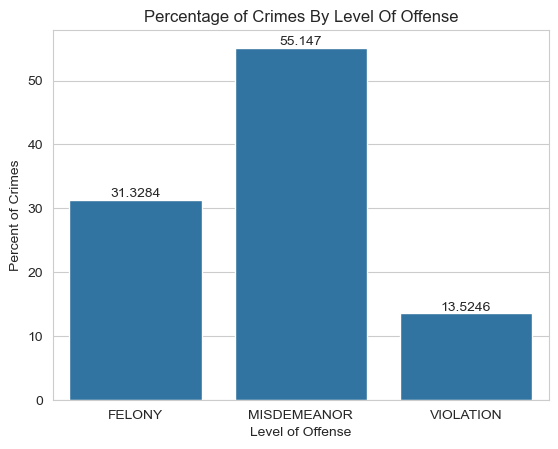

In [45]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Crimes By Level Of Offense')
ax.bar_label(ax.containers[0]);

In [48]:
data.index

RangeIndex(start=0, stop=8914838, step=1)

In [60]:
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 11/19/1015, at position 4697572. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [59]:
dt_data.index

Index(['01/01/1948', '01/01/1955', '01/01/1955', '01/01/1961', '01/01/1964',
       '01/01/1964', '01/01/1965', '01/01/1967', '01/01/1967', '01/01/1967',
       ...
                nan,          nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,          nan],
      dtype='object', name='CMPLNT_FR_DT', length=8914838)

In [55]:
dt_data = data.set_index(data['CMPLNT_FR_DT'], drop=True).sort_index()
dt_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
01/01/1948,47950156,01/01/1948,04:00:00,06/28/2008,02:51:00,105.0,07/02/2008,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.694620,-73.735327,"(40.69462, -73.735327)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F
01/01/1955,226616730,01/01/1955,00:01:00,12/31/1957,00:59:00,123.0,04/07/2021,116,SEX CRIMES,177.0,...,(null),NaN,40.512038,-74.249755,"(40.5120382535219, -74.2497549524458)",PATROL BORO STATEN ISLAND,(null),65+,WHITE,F
01/01/1955,221569468,01/01/1955,10:00:00,01/01/1967,10:00:00,62.0,12/09/2020,116,SEX CRIMES,177.0,...,M,NaN,40.602216,-74.002951,"(40.6022161657077, -74.0029507988395)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F
01/01/1961,249596456,01/01/1961,00:00:00,12/31/1961,23:59:00,19.0,08/15/2022,116,SEX CRIMES,177.0,...,(null),NaN,40.766996,-73.963922,"(40.7669956423899, -73.9639223035387)",PATROL BORO MAN NORTH,(null),65+,WHITE,M
01/01/1964,252593706,01/01/1964,00:01:00,NaN,(null),42.0,10/14/2022,116,SEX CRIMES,177.0,...,M,NaN,40.822271,-73.911698,"(40.8222710411331, -73.911697780277)",PATROL BORO BRONX,(null),45-64,UNKNOWN,M


In [58]:
# Resample data to yearly and plot time series
data_yearly = dt_data.resample('YE').sum()
ax.plot(data_yearly)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

## Data Preparation

## Feature Engineering

# Modeling

## Baseline Model

## Modeline Iterations

## Final Model

# Conclusion

## Limitations

## Next Steps